In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
import os
import time

from pyspark.sql.types import StringType, ArrayType, BooleanType
from IPython.display import display, clear_output,Image

# 1. Setup the input, output path for image and model

In [3]:
image_input_folder_path = "/tmp/sparkcv/input/"
faces_output_path = "/tmp/sparkcv/output/faces"
final_output_path = "/tmp/sparkcv/output/final"
cascade_model_path = "/mnt/hgfs/Centos7_share_folder/trained_models"
cascade_model_name = "haarcascade_frontalface_default.xml"
vgg19_model_path = "/mnt/hgfs/Centos7_share_folder/trained_models"
vgg19_model_name = "masknet.h5"


# 2. Create a spark session

In [4]:
spark = SparkSession.builder \
    .master("local") \
    .appName("StreamingExample") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()

## 2.1 helper functions

### 2.1.1 face extraction spark udf

In [5]:
def face_extraction(image_name):
    image_path = image_input_folder_path + image_name

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    face_model = cv2.CascadeClassifier("{}/{}".format(cascade_model_path,cascade_model_name))
    faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)  # returns a list of (x,y,w,h) tuples
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Extract faces from the origin image
    extracted_face_list = []
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        crop = img[y:y + h, x:x + w]
        extracted_face_img_name = image_name[:-4] + "_x" + str(x) + "_y" + str(y) + "_w" + str(
            w) + "_h" + str(h) + ".png"
        extracted_face_list.append(extracted_face_img_name)
        extracted_face_output_path = "{}/{}".format(faces_output_path, extracted_face_img_name)
        cv2.imwrite(extracted_face_output_path, crop)

    return extracted_face_list

Face_Extraction_UDF = f.udf(lambda image_name: face_extraction(image_name), ArrayType(StringType()))


### 2.1.2 column function for extract image name


In [6]:
def extract_file_name(path):
    return f.substring_index(path, "/", -1)

### 2.1.3 mask detection spark udf


In [7]:
# This function use a pre-trained vgg19 model to predict if it has mask or no. It returns true, if it has mask.
def face_mask_prediction(face_image_name):
    # read raw face image
    img = cv2.imread("{}/{}".format(faces_output_path, face_image_name))
    # normalize the raw image for vgg19 model
    img = cv2.resize(img, (128, 128))
    # plt.imshow(img)
    # plt.show()
    img = np.reshape(img, [1, 128, 128, 3])
    img = img / 255.0
    vgg19_model = tf.keras.models.load_model("{}/{}".format(vgg19_model_path, vgg19_model_name))
    score = vgg19_model.predict(img)
    if np.argmax(score) == 0:
        res = True
    else:
        res = False
    # print(res)
    return res


Face_Mask_Prediction_UDF = f.udf(lambda face_image_name: face_mask_prediction(face_image_name), BooleanType())

### 2.1.4 get face position in origin image

In [8]:
def get_face_coordinate_of_origin_image(face_image_name):
    x = face_image_name.split("_")[1][1:]
    y = face_image_name.split("_")[2][1:]
    w = face_image_name.split("_")[3][1:]
    h = face_image_name.split("_")[4][1:].split('.')[0]
    return int(x), int(y), int(w), int(h)

### 2.1.5 prediction integration spark udf


In [9]:
def integrate_face_mask_prediction(face_image_name, origin_image_name, has_mask):
    # check if the image is already treated or not, if yes, it means it has multiple faces. and we just add new mask
    # prediction to untreated faces.
    # If not treated, we load image from
    treated_image_path = "{}/{}".format(final_output_path, origin_image_name)
    # If the image is treated, update the treated image
    if os.path.isfile(treated_image_path):
        image = cv2.imread(treated_image_path)
    else:
        # Get the untreated image from input
        image = cv2.imread("{}/{}".format(image_input_folder_path, origin_image_name))

    # set Label text
    if has_mask:
        mask_label = "MASK"
    else:
        mask_label = "NO MASK"
    # Get the coordinate and size of face image
    (x, y, w, h) = get_face_coordinate_of_origin_image(face_image_name)

    # Set text color for mask label
    mask_label_color = {"MASK": (0, 255, 0), "NO MASK": (0, 0, 255)}

    # Insert mask label to image
    image = cv2.putText(image, mask_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        mask_label_color[mask_label], 2)
    # Insert a rectangle around the face
    image = cv2.rectangle(image, (x, y), (x + w, y + h), mask_label_color[mask_label], 1)
    # Save the image
    cv2.imwrite(treated_image_path, image)

    return "Done"


Integrate_Face_Mask_Prediction_UDF = f.udf(
    lambda face_image_name, origin_image_name, has_mask: integrate_face_mask_prediction(face_image_name,
                                                                                        origin_image_name, has_mask))

In [10]:
def show_df(df, epoch_id):
    df.show(5, False)
    pass


### 2.1.6 render image in jupyter notebook




In [11]:
def render_image(image_folder_path, image_list):
    for image_name in image_list:
        image_path = "{}/{}".format(image_folder_path,image_name)
        display(Image(filename=image_path))


# 3. Process image

To check if everyone wears a face mask or not in an image, we will follow the below steps:
1. Read raw image
2. Detect faces from the raw image, output extracted faces as single images(haar-cascade)
3. Use a pre-trained vgg19 model to check if a mask is worn
4. Integrate prediction as tags on origin image

## 3.1 Read raw image

In [12]:
image_schema = spark.read.format("binaryFile").load(image_input_folder_path).schema
raw_image_df_stream = spark.readStream \
    .format("binaryFile") \
    .schema(image_schema) \
    .option("maxFilesPerTrigger", "500") \
    .option("recursiveFileLookup", "true") \
    .option("pathGlobFilter", "*.png") \
    .load(image_input_folder_path) \
    .withColumn("time_stamp", f.current_timestamp())


## 3.2 Detect faces and output extracted each face as a single image

In [13]:
# get the image name df
image_name_df = raw_image_df_stream \
    .select("path","time_stamp") \
    .withColumn("origin_image_name", extract_file_name(f.col("path"))) \
    .drop("path")

# run the face detection function on each row
detected_face_list_df = image_name_df.withColumn("detected_face_list", Face_Extraction_UDF("origin_image_name"))

detected_face_df = detected_face_list_df \
                   .withColumn("extracted_face_image_name",f.explode(f.col("detected_face_list")))\
                   .drop("detected_face_list")

## 3.3 predict if the face wear mask or not

In [14]:
predict_mask_df_stream = detected_face_df.withColumn("has_mask",
                                                    Face_Mask_Prediction_UDF("extracted_face_image_name"))


## 3.4: Integrate faces with tag to origin image


In [15]:
complete_df_stream = predict_mask_df_stream.withColumn("integration",
                                                Integrate_Face_Mask_Prediction_UDF("extracted_face_image_name",
                                                                                   "origin_image_name",
                                                                                   "has_mask"))

In [16]:
query_list=spark.streams.active
    
print(query_list)

[]


# 4. View the output data frame and image

In [17]:

# stream = raw_image_df_stream.writeStream \
#     .format("memory") \
#     .option("truncate", "false") \
#     .trigger(processingTime='2 seconds') \
#     .queryName("raw_image_df_stream") \
#     .start()

stream = complete_df_stream.withWatermark("time_stamp", "10 seconds") \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("raw_image_df_stream") \
    .start()

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

+-----------------------+-------------------+--------------------------------------+--------+-----------+
|time_stamp             |origin_image_name  |extracted_face_image_name             |has_mask|integration|
+-----------------------+-------------------+--------------------------------------+--------+-----------+
|2021-06-02 14:12:50.125|maksssksksss244.png|maksssksksss244_x296_y21_w102_h102.png|false   |Done       |
|2021-06-02 14:12:50.125|maksssksksss244.png|maksssksksss244_x170_y59_w58_h58.png  |true    |Done       |
|2021-06-02 14:12:50.125|maksssksksss244.png|maksssksksss244_x47_y97_w54_h54.png   |false   |Done       |
|2021-06-02 14:12:50.125|maksssksksss14.png |maksssksksss14_x140_y175_w116_h116.png|false   |Done       |
|2021-06-02 14:14:45.63 |maksssksksss809.png|maksssksksss809_x284_y33_w58_h58.png  |true    |Done       |
|2021-06-02 14:14:45.63 |maksssksksss809.png|maksssksksss809_x18_y67_w56_h56.png   |false   |Done       |
|2021-06-02 14:14:45.63 |maksssksksss809.png|m

None

0     maksssksksss14.png
1    maksssksksss244.png
2     maksssksksss83.png
3    maksssksksss809.png
Name: origin_image_name, dtype: object

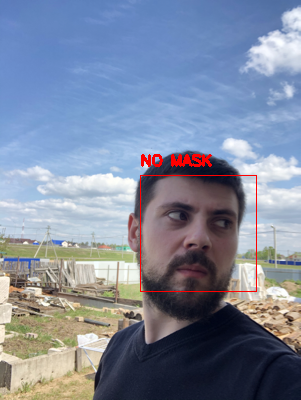

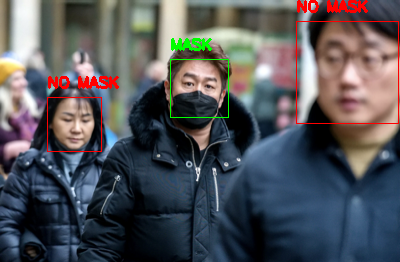

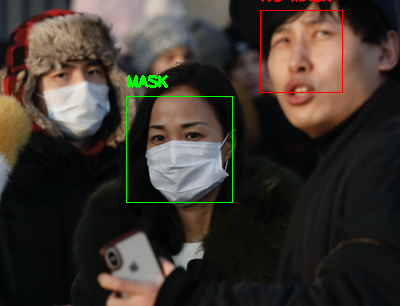

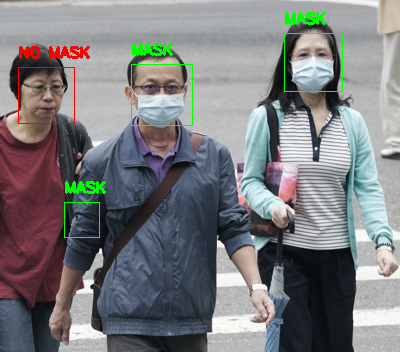

In [19]:
for x in range(20):
    clear_output(wait=True)
    display(stream.status)
    _df=spark.sql('SELECT * FROM raw_image_df_stream')
    col_name="origin_image_name"
    if _df.count()>0:
        display(_df.show(10,False))
        img_list=_df.select(col_name).distinct().toPandas()[col_name]
        display(img_list)
        render_image(final_output_path,img_list)
    time.sleep(5)


In [ ]:
stream.awaitTermination(200)

In [20]:
stream.stop()